## Importaciones

In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

## Generación del conjunto de datos

In [2]:
credit = pd.read_csv('./datos/credit.csv', usecols=list(range(1,13)))
del credit['ID']
credit.head(3)

credit = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'], drop_first = True)

Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)

## Best subsets

In [3]:
def fit_linear_reg(X,Y):

    X = sm.add_constant(X.astype(float))
    model_k = sm.OLS(Y, X)
    modelo = model_k.fit()

    return modelo.aic, modelo.bic, modelo.rsquared_adj

def best_subsets(X, y, k):

    R_squared_adj_list, aic_list, bic_list, feature_list, num_features = [], [], [], [], []

    # Best subset selection
    for k in range(1,len(X.columns)): # Para cada uno de los k predictores

        for combo in itertools.combinations(X.columns, k): # Para cada una de las combinaciones posibles
            aic, bic, rsquared_adj = fit_linear_reg(X[list(combo)], y)
            R_squared_adj_list.append(rsquared_adj)
            aic_list.append(aic)
            bic_list.append(bic)
            feature_list.append(combo)
            num_features.append(len(combo))


    # Procesamos los resultados
    df = pd.DataFrame({'numb_features': num_features, 'R_squared_adj':R_squared_adj_list,
                    'AIC': aic_list, 'BIC' : aic_list, 'features':feature_list})

    df['min_AIC'] = df.groupby('numb_features')['AIC'].transform(min)
    df['min_BIC'] = df.groupby('numb_features')['BIC'].transform(min)
    df['max_R_squared_adj'] = df.groupby('numb_features')['R_squared_adj'].transform(max)


    # Representamos las gráficas de ajuste
    fig = plt.figure(figsize = (16, 6))

    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(df.numb_features,df.R_squared_adj, alpha = .2, color = 'darkblue' )
    ax.plot(df.numb_features,df.max_R_squared_adj,color = 'r', label = 'Best subset')
    ax.set_xlabel('# Features')
    ax.set_ylabel('R squared adj')
    ax.set_title('R_squared_adj - Best subset selection')
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.scatter(df.numb_features,df.AIC, alpha = .2, color = 'darkblue' )
    ax.set_xlabel('# Features')
    ax.set_ylabel('AIC')
    ax.set_title('AIC - Best subset selection')
    ax.plot(df.numb_features,df.min_AIC, color = 'r', label = 'Best subset')
    ax.legend()

    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(df.numb_features,df.BIC, alpha = .2, color = 'darkblue' )
    ax.set_xlabel('# Features')
    ax.set_ylabel('BIC')
    ax.set_title('BIC - Best subset selection')
    ax.plot(df.numb_features,df.min_BIC, color = 'r', label = 'Best subset')
    ax.legend()

    plt.show()

    return df

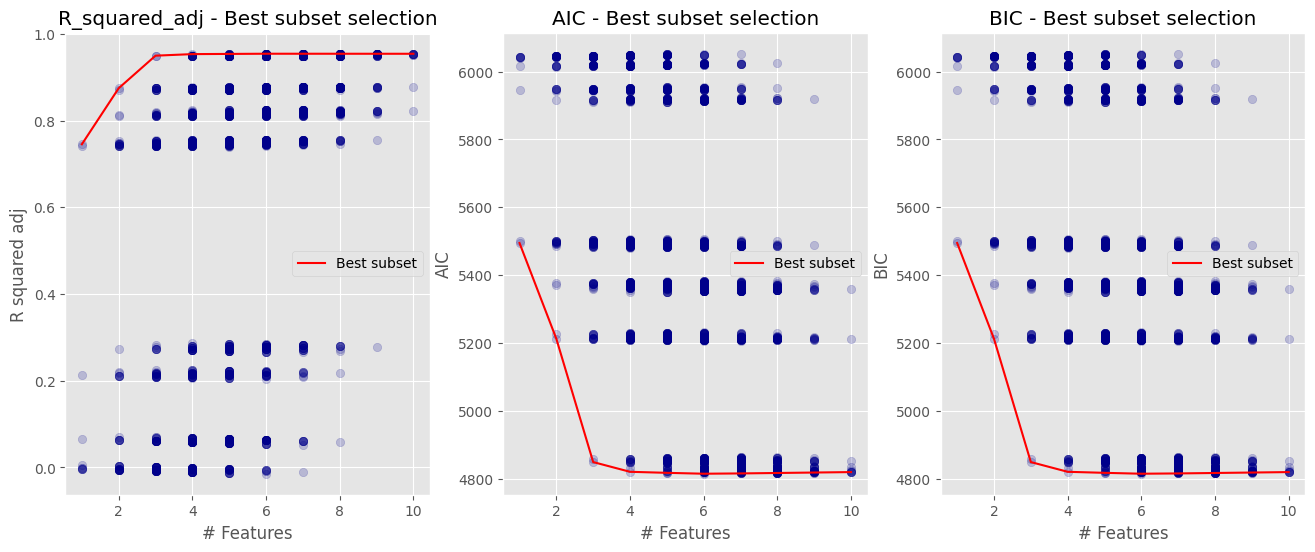

In [4]:
resultado = best_subsets(X, Y, k=11)

In [6]:
a = resultado.sort_values("AIC")
a.loc[a.numb_features == 3].sort_values("AIC").head(5)

numb_features  R_squared_adj          AIC          BIC   
79              3       0.949499  4849.386992  4849.386992  \
71              3       0.948427  4857.793213  4857.793213   
80              3       0.875308  5210.930247  5210.930247   
66              3       0.875301  5210.950291  5210.950291   
76              3       0.875250  5211.113461  5211.113461   

                         features      min_AIC      min_BIC  max_R_squared_adj  
79  (Income, Rating, Student_Yes)  4849.386992  4849.386992           0.949499  
71   (Income, Limit, Student_Yes)  4849.386992  4849.386992           0.949499  
80  (Income, Rating, Married_Yes)  4849.386992  4849.386992           0.949499  
66        (Income, Limit, Rating)  4849.386992  4849.386992           0.949499  
76          (Income, Rating, Age)  4849.386992  4849.386992           0.949499

In [7]:
resultado.sort_values("AIC").head(5)

numb_features  R_squared_adj          AIC          BIC   
1025              6       0.953996  4815.038963  4815.038963  \
1490              7       0.954010  4815.900560  4815.900560   
1495              7       0.953947  4816.450378  4816.450378   
1494              7       0.953945  4816.468057  4816.468057   
1486              7       0.953942  4816.489953  4816.489953   

                                               features      min_AIC   
1025   (Income, Limit, Rating, Cards, Age, Student_Yes)  4815.038963  \
1490  (Income, Limit, Rating, Cards, Age, Gender_Fem...  4815.900560   
1495  (Income, Limit, Rating, Cards, Age, Student_Ye...  4815.900560   
1494  (Income, Limit, Rating, Cards, Age, Student_Ye...  4815.900560   
1486  (Income, Limit, Rating, Cards, Age, Education,...  4815.900560   

          min_BIC  max_R_squared_adj  
1025  4815.038963           0.953996  
1490  4815.900560           0.954010  
1495  4815.900560           0.954010  
1494  4815.900560           0.954010  
1486  4815.900560           0.954010

## Forward subsets

In [8]:
def fit_linear_reg(X,Y):

    X = sm.add_constant(X.astype(float))
    model_k = sm.OLS(Y, X)
    modelo = model_k.fit()
    RSS = mean_squared_error(Y,modelo.predict(X)) * len(Y)

    return modelo.aic, modelo.bic, modelo.rsquared_adj, RSS


def forward_subsets(X, y, k):

    bolsa_features = list(X.columns.values)
    R_squared_adj_list, aic_list, bic_list, features, feature_list, n_features = [], [], [], [], [], []
    mejor_RSS, mejor_aic, mejor_bic, mejor_r2 = [np.inf, np.inf, np.inf, 0.0]

    # Forward subset selection
    for k in range(1, k+1): # Hasta llegar al número de predictores propuesto
        for combo in itertools.combinations(bolsa_features, 1): # Bolsa que contiene los predictores aún no usados
            aic, bic, rsquared_adj, RSS = fit_linear_reg(X[list(combo) + features], y)

            # El RSS siempre es decreciente
            if RSS <= mejor_RSS:
                mejor_aic = aic
                mejor_bic = bic
                mejor_RSS = RSS

                mejor_r2 = rsquared_adj
                mejor_feature = combo[0]
                

        # Actualizamos las variables
        features.append(mejor_feature)
        bolsa_features.remove(mejor_feature)

        R_squared_adj_list.append(mejor_r2)
        aic_list.append(mejor_aic)
        bic_list.append(mejor_bic)
        n_features.append(len(features))
        feature_list.append(", ".join(features))

    # Procesamos los resultados
    df = pd.DataFrame({'n_features' :n_features, 'R_squared_adj':R_squared_adj_list,
                       'AIC': aic_list, 'BIC' : aic_list, 'features': feature_list})

    
    # Representamos los resultados
    fig = plt.figure(figsize = (16, 6))

    ax = fig.add_subplot(1, 3, 1)

    minimo_idx = np.where(df.R_squared_adj == max(df.R_squared_adj))[0]
    minimo = df.loc[int(minimo_idx),:]

    ax.plot(df.n_features,df.R_squared_adj, color = 'r')
    ax.set_xlabel('# Features')
    ax.set_ylabel('R squared adj')
    ax.set_title(f'R_squared_adj - Forward - {str(minimo.n_features)} vars')
    ax.axvline(x = minimo.n_features, color = 'b', linestyle = 'dashed')


    ax = fig.add_subplot(1, 3, 2)

    minimo_idx = np.where(df.AIC == min(df.AIC))[0]
    minimo = df.loc[int(minimo_idx),:]

    ax.plot(df.n_features,df.AIC, color = 'r' )
    ax.set_xlabel('# Features')
    ax.set_ylabel('AIC')
    ax.set_title(f'AIC - Forward - {str(minimo.n_features)} vars')
    ax.axvline(x = minimo.n_features, color = 'b', linestyle = 'dashed')


    ax = fig.add_subplot(1, 3, 3)
    minimo_idx = np.where(df.BIC == min(df.BIC))[0]
    minimo = df.loc[int(minimo_idx),:]

    ax.plot(df.n_features,df.BIC, color = 'r' )
    ax.set_xlabel('# Features')
    ax.set_ylabel('BIC')
    ax.set_title('BIC - Forward subset selection')
    ax.set_title(f'BIC - Forward - {str(minimo.n_features)} vars')
    ax.axvline(x = minimo.n_features, color = 'b', linestyle = 'dashed')

    plt.show()

    return df

C:\Users\agonz\AppData\Local\Temp\ipykernel_8676\1246315171.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  minimo = df.loc[int(minimo_idx),:]
C:\Users\agonz\AppData\Local\Temp\ipykernel_8676\1246315171.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  minimo = df.loc[int(minimo_idx),:]
C:\Users\agonz\AppData\Local\Temp\ipykernel_8676\1246315171.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  minimo = df.loc[int(minimo_idx),:]


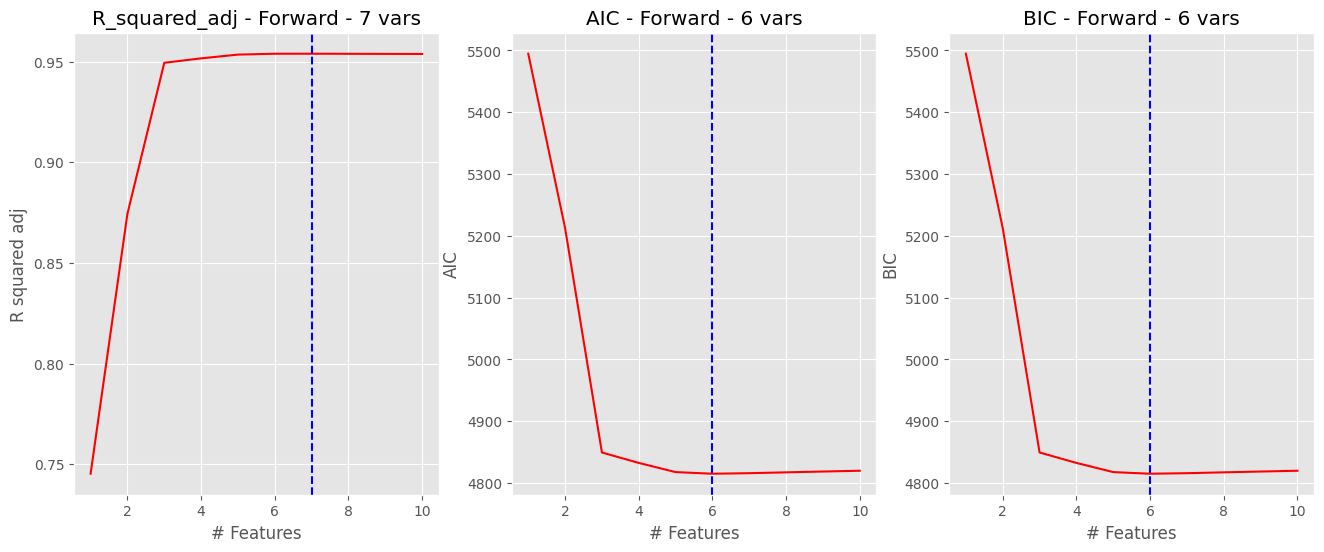

In [9]:
resultado = forward_subsets(X, Y, k=10)

In [11]:
resultado.sort_values("AIC").head(5)

n_features  R_squared_adj          AIC          BIC   
5           6       0.953996  4815.038963  4815.038963  \
6           7       0.954010  4815.900560  4815.900560   
7           8       0.953965  4817.268900  4817.268900   
4           5       0.953579  4817.666820  4817.666820   
8           9       0.953924  4818.597738  4818.597738   

                                            features  
5     Rating, Income, Student_Yes, Limit, Cards, Age  
6  Rating, Income, Student_Yes, Limit, Cards, Age...  
7  Rating, Income, Student_Yes, Limit, Cards, Age...  
4          Rating, Income, Student_Yes, Limit, Cards  
8  Rating, Income, Student_Yes, Limit, Cards, Age...